# Mismatch

On this experiment we are going calculate the FF curve for different neurons with a mismatch of 10% on the synaptic weights. First, we are going to import the necesary libraries and set the simulation timestep.

In [ ]:
!pip install git+https://github.com/ferqui/DynapSEtorch.git

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

from dynapsetorch.model import AdexLIF

timestep = 20 * 1e-6

## Input generation
We are going to create a total of 16 neurons with an input spike frequency in the range [0, 500]Hz in steps of 30Hz

In [2]:
freq = np.arange(0, 200, 1)

In [3]:
# Parameters
pulse_start = 0  # second - Start time of input (Default: 0)
pulse_stop = 1  # second - Stop time of input (Default: 5)
inp_duration = 0.2  # second - Simulation duration (Default: 5)
rate = 30  # Hz or rad/sec - Spiking rate (Default: 80 Hz for regular, 100 Hz for poission, 2 rad/sec for cosine)
##################

spikes = torch.zeros(len(freq), int(inp_duration / timestep))

for i, rate in enumerate(freq[1:]):
    dt = int((1 / timestep) / rate)
    spikes[
        i + 1, pulse_start * int(1 / timestep) : pulse_stop * int(1 / timestep) : dt
    ] = 1.0

spikes = spikes.transpose(0, 1)
input = spikes.unsqueeze(0).cuda()

Text(0.5, 0, 'Time (s)')

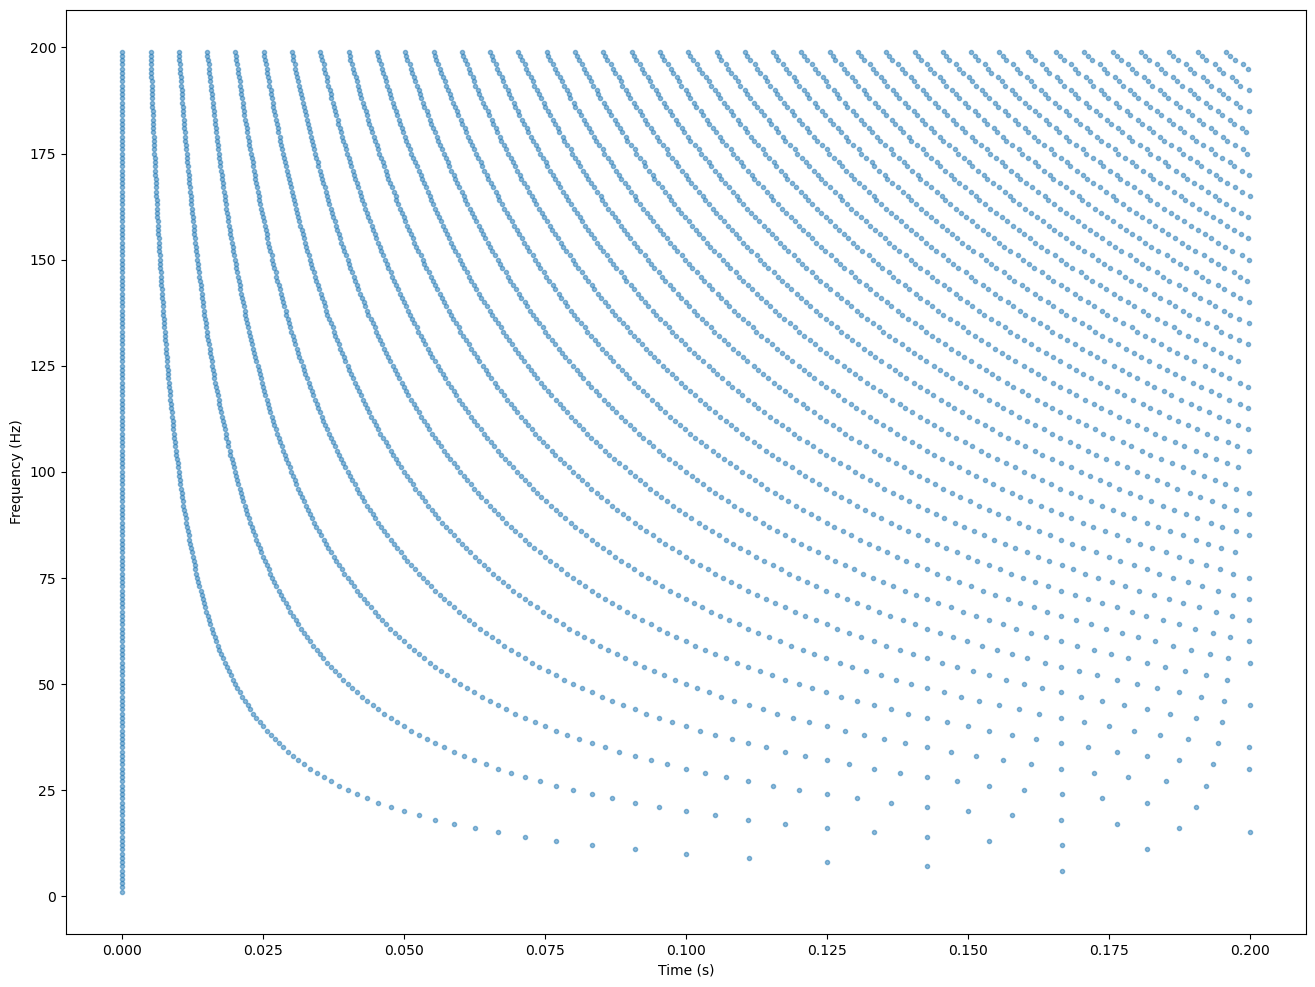

In [4]:
t, b = np.where(spikes)
plt.figure(figsize=(16, 12))
plt.scatter(t * timestep, freq[b], marker=".", alpha=0.5)
# plt.yscale(u'log')
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")

## Model creating and simulation

Once we created the input, we instantiate a layer of 16 AdexLIF neurons with an AMPA synapse connected to each input. The simulation is processed in batches, where each batch correspond to a determinated frequency.

In [5]:
network = AdexLIF(num_neurons=len(freq), input_per_synapse=[len(freq), 0, 0, 0]).cuda()
network.dt = timestep
output = []

with torch.no_grad():
    network.weight_nmda.data = torch.eye(len(freq), device="cuda") * 0.7
    network.state = network.init_state(input[:, 0])
    for t in trange(input.shape[1]):
        output.append(network(input_nmda=input[:, t]))
    output_mean = torch.stack(output, dim=1).detach().cpu()

100%|██████████| 10000/10000 [01:37<00:00, 102.16it/s]


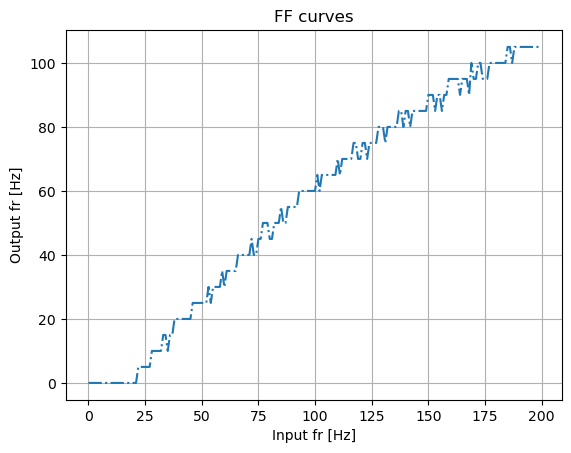

In [6]:
plt.plot(freq, output_mean.sum(dim=(0, 1)) / inp_duration, "-.")
plt.xlabel("Input fr [Hz]")
plt.ylabel("Output fr [Hz]")
plt.title("FF curves")
plt.grid()
plt.show()